In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

from cost_functions import cross_entropy
import cost_functions
from evaluation import Evaluator
from my_datasets.reid_dataset import Market1501
from utils.split_data import ValidationSplitter, TrainingSplitter
from models.reid_model import ReIdModel, FinetunedModel
from sklearn.model_selection import train_test_split

In [2]:
config = dict(
    wandb = False,
    device = "auto", # Select an specific device None to select automatically
    train_root = "dataset/train",
    test_root = "dataset/test",
    queries_root = "dataset/queries",
    attributes_file = "dataset/annotations_train.csv",
    # train_root = "/media/deayalar/Data/Documents/Unitn/Deep Learning/Assignment/dataset/train",
    # test_root = "/media/deayalar/Data/Documents/Unitn/Deep Learning/Assignment/dataset/test",
    # queries_root = "/media/deayalar/Data/Documents/Unitn/Deep Learning/Assignment/dataset/queries",
    # attributes_file = "/media/deayalar/Data/Documents/Unitn/Deep Learning/Assignment/dataset/annotations_train.csv",
    dataset="Market1501",
    backbone = "resnet18",
    loss = cross_entropy(),
    split = dict(
        full_training_size = 0.75,
        train_size = 0.8
    ),
    compose = dict(
        resize_h = 224,
        resize_w = 224
    ),
    epochs=1,
    training_batch_size=32,
    validation_batch_size=32,
    learning_rate=0.01,
    weight_decay=0.000001, 
    momentum=0.9, 
    mAP_rank=10)

In [3]:
def split_data(config):
    print('split_data OK!')
    splitter = ValidationSplitter(train_root=config["train_root"], 
                                  test_root=config["test_root"], 
                                  queries_root=config["queries_root"])
    train_set, val_set, val_queries = splitter.split(train_size=config["split"]["full_training_size"],
                                                     random_seed=42)
    return train_set, val_set, val_queries
train_set, val_set, val_queries = split_data(config)

split_data OK!
Extract queries proportion: 0.11
Identities in train set: 563
Identities in validation set: 188
Train set size: 9723
Validation set size: 2906
Number of validation queries: 360


In [4]:
from my_datasets.reid_dataset import Market1501

#Create pytorch Datasets 
composed = transforms.Compose([transforms.Resize((config["compose"]["resize_h"], 
                                                  config["compose"]["resize_w"])),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                    std=[0.229, 0.224, 0.225])])

train_dataset = Market1501(root_dir=config["train_root"],
                        attributes_file=config["attributes_file"],
                        #full_train_set=full_train_set,
                        images_list=train_set,
                        transform=composed)




In [5]:
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                            batch_size=config["training_batch_size"], 
                                            shuffle=True, 
                                            # num_workers=8
                                            num_workers=4)
                                            
# val_loader = torch.utils.data.DataLoader(val_dataset, 
#                                             batch_size=config["validation_batch_size"], 
#                                             shuffle=False, 
#                                             num_workers=8)

C:\Python39\lib\site-packages\torch\utils\data\dataloader.py:474: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [6]:
'''
Let's take the backbone. weights trained. 

'''

def initialize_alexnet(num_classes):
    # load the pre-trained Alexnet
    alexnet = torchvision.models.alexnet(pretrained=True)
  
    # get the number of neurons in the penultimate layer
    in_features = alexnet.classifier[6].in_features
    
    # re-initalize the output layer
    alexnet.classifier[6] = torch.nn.Linear(in_features=in_features, 
                                            out_features=num_classes)
    
    return alexnet


def get_cost_function():
    cost_function = torch.nn.CrossEntropyLoss()
    return cost_function

def get_optimizer(model, lr, wd, momentum):
  
    # we will create two groups of weights, one for the newly initialized layer
    # and the other for rest of the layers of the network
    
    final_layer_weights = []
    rest_of_the_net_weights = []
    
    # we will iterate through the layers of the network
    for name, param in model.named_parameters():
        if name.startswith('classifier.6'):
            final_layer_weights.append(param)
        else:
            rest_of_the_net_weights.append(param)
    
    # so now we have divided the network weights into two groups.
    # We will train the final_layer_weights with learning_rate = lr
    # and rest_of_the_net_weights with learning_rate = lr / 10
    
    optimizer = torch.optim.SGD([
        {'params': rest_of_the_net_weights},
        {'params': final_layer_weights, 'lr': lr}
    ], lr=lr / 10, weight_decay=wd, momentum=momentum)
    
    return optimizer


def train(net,data_loader,optimizer,cost_function, device='cuda:0'):
    samples = 0.
    cumulative_loss = 0.
    cumulative_accuracy = 0.

    
    net.train() # Strictly needed if network contains layers which has different behaviours between train and test
    for batch_idx, (inputs, targets) in enumerate(data_loader):
        # Load data into GPU
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # Forward pass
        outputs = net(inputs)

        # Apply the loss
        loss = cost_function(outputs,targets)
        
        # Backward pass
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        # Resets the gradients
        optimizer.zero_grad()

        # Better print something, no?
        samples+=inputs.shape[0]
        cumulative_loss += loss.item()
        _, predicted = outputs.max(1)
        cumulative_accuracy += predicted.eq(targets).sum().item()

    return cumulative_loss/samples, cumulative_accuracy/samples*100

In [7]:
def main(train_loader,
        batch_size=128, 
         device='cuda:0', 
         learning_rate=0.001, 
         weight_decay=0.000001, 
         momentum=0.9, 
         epochs=50, 
         num_classes=27, 
         visualization_name='alexnet_sgd', 
         img_root=None,
         ):
  
#   writer = SummaryWriter(log_dir="runs/exp1")

  # Instantiates dataloaders
#   train_loader, test_loader = get_data(batch_size=batch_size, img_root=img_root)
  
  # Instantiates the model
  net = initialize_alexnet(num_classes=num_classes).to(device)
  
  # Instantiates the optimizer
  optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)
  
  # Instantiates the cost function
  cost_function = get_cost_function()

#   print('Before training:')
#   train_loss, train_accuracy = test(net, train_loader, cost_function)
#   test_loss, test_accuracy = test(net, test_loader, cost_function)

#   print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
#   print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
#   print('-----------------------------------------------------')
  
  # Add values to plots
#   writer.add_scalar('Loss/train_loss', train_loss, 0)
#   writer.add_scalar('Loss/test_loss', test_loss, 0)
#   writer.add_scalar('Accuracy/train_accuracy', train_accuracy, 0)
#   writer.add_scalar('Accuracy/test_accuracy', test_accuracy, 0)

  for e in range(epochs):
    train_loss, train_accuracy = train(net, train_loader, optimizer, cost_function)
    # test_loss, test_accuracy = test(net, test_loader, cost_function)
    print('Epoch: {:d}'.format(e+1))
    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    # print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
    print('-----------------------------------------------------')
    
    # Add values to plots
    writer.add_scalar('Loss/train_loss', train_loss, e + 1)
    # writer.add_scalar('Loss/test_loss', test_loss, e + 1)
    writer.add_scalar('Accuracy/train_accuracy', train_accuracy, e + 1)
    # writer.add_scalar('Accuracy/test_accuracy', test_accuracy, e + 1)

  print('After training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
#   test_loss, test_accuracy = test(net, test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
#   print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  # Closes the logger
#   writer.close()

In [8]:
main(train_loader,
        batch_size=128, 
         device='cpu', 
         learning_rate=0.001, 
         weight_decay=0.000001, 
         momentum=0.9, 
         epochs=50, 
         num_classes=27, 
         visualization_name='alexnet_sgd', 
         img_root=None,
         )

AssertionError: Torch not compiled with CUDA enabled

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


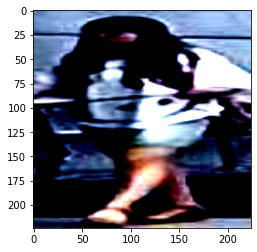

(tensor([[[ 0.3652,  0.3652,  0.3652,  ...,  0.6392,  0.6392,  0.6392],
         [ 0.3652,  0.3652,  0.3652,  ...,  0.6392,  0.6392,  0.6392],
         [ 0.3481,  0.3481,  0.3481,  ...,  0.6221,  0.6221,  0.6221],
         ...,
         [-0.0801, -0.0801, -0.0801,  ...,  0.6392,  0.6392,  0.6392],
         [-0.0287, -0.0287, -0.0287,  ...,  0.7077,  0.7077,  0.7077],
         [ 0.0056,  0.0056,  0.0056,  ...,  0.7419,  0.7419,  0.7419]],

        [[ 0.5028,  0.5028,  0.5028,  ...,  0.7829,  0.7829,  0.7829],
         [ 0.5028,  0.5028,  0.5028,  ...,  0.7829,  0.7829,  0.7829],
         [ 0.4853,  0.4853,  0.4853,  ...,  0.7654,  0.7654,  0.7654],
         ...,
         [ 0.0301,  0.0301,  0.0301,  ...,  0.6604,  0.6604,  0.6604],
         [ 0.0826,  0.0826,  0.0826,  ...,  0.7304,  0.7304,  0.7304],
         [ 0.1176,  0.1176,  0.1176,  ...,  0.7654,  0.7654,  0.7654]],

        [[ 0.7228,  0.7228,  0.7228,  ...,  1.0017,  1.0017,  1.0017],
         [ 0.7228,  0.7228,  0.7228,  ...,  

In [6]:
from utils import image_utils
image_utils.imshow(train_dataset[10][0])
print(train_dataset[10])

In [8]:
print(len(train_dataset.attr))
print(len(train_dataset.class_to_idx))

563
563


In [ ]:
from utils import image_utils
print(train_dataset.images_list[0])
print(image_utils.get_ids_from_images(train_dataset.images_list)[0])
image_utils.imshow(train_dataset[0][0])


In [ ]:
train_dataset.__init__(root_dir=config["train_root"],
                        attributes_file=config["attributes_file"], images_list=img_l).__getitem__()

In [ ]:
img_l = train_dataset.images_list

In [ ]:
train_dataset.__getitem__(int('0901'))

In [ ]:
train_dataset.__getitem__(int('0901'))

In [ ]:
idx = train_dataset.class_to_idx.keys()
# idx
train_dataset.__getitem__(int('0901'))

In [ ]:
train_dataset